In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
import pandas as pd
import configs
import torch
from sklearn.decomposition import PCA
from scipy.spatial.distance import pdist, squareform

from src.utils import find_ckpt_file, convert_to_tensor
import h5py
import random
from src.evals.eval_trees import EvalTrees
from copy import copy
from src.models.dqn import DQN

/n/home04/cfang/.conda/envs/jax/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load Model

In [2]:
engram_dir = "/n/holylfs06/LABS/krajan_lab/Lab/cfang/icl-maze/"
wandb_project = "dqn_full"
env_name = "tree_layers7_bprob1.0_envs200_H2000_explore"
model_name = "dqn_nlayers4_gamma0.9_target10_lr1e-05"

In [7]:
# Extract parameters using regex
import re
n_layer = int(re.search(r'nlayers(\d+)', model_name).group(1))
gamma = float(re.search(r'gamma(\d*\.?\d*)', model_name).group(1))
target_update = int(re.search(r'target(\d+)', model_name).group(1))
lr = float(re.search(r'lr(\d*\.?\d*)', model_name).group(1))


model_config = {
    "state_dim": 10,
    "action_dim": 4,
    "n_layers": n_layer,
    "gamma": gamma,
    "epsilon": 0.,
    "target_update": target_update,
    "optimizer_config": {'lr': lr, 'weight_decay': 0, 'batch_size': 512},
    "name": "dqn",
    "buffer_size": None,
}

# Load Dataset and Create Environment

In [8]:
eval_dataset_path = "/n/holylfs06/LABS/krajan_lab/Lab/cfang/icl-maze/datasets/tree_layers7_bprob1.0_envs600000_H1600_explore/eval.h5"
eval_trajs = h5py.File(eval_dataset_path, 'r')
traj_indices = list(eval_trajs.keys())
n_eval_envs = min(50, len(traj_indices))
random.seed(0)
traj_indices = random.sample(traj_indices, n_eval_envs)
random.seed()
eval_trajs = [eval_trajs[i] for i in traj_indices]


In [18]:
def run_model(traj, model, state_features, seq_length):
    hidden_states = None
    
    for state_feature in state_features: 
        query_state  = convert_to_tensor([np.array(state_feature)])
        with torch.no_grad():
            out, _hidden_states = model(query_state, return_activations=True)
        if hidden_states is None:
            hidden_states = [[] for _ in range(len(_hidden_states))]
        for i_layer, h in enumerate(_hidden_states):
            hidden_states[i_layer].append(h.squeeze())
    return hidden_states

In [19]:
def get_node_and_representation(traj, env, model):
    nodes = []
    state_features = []
    state_features = list(env.node_map.keys())

    nodes = [] 
    for state_feature in state_features:
        nodes.append(str(env.node_map[state_feature]))
    hidden_states = run_model(traj, model, state_features, seq_length=1000)

    return nodes, hidden_states

In [20]:
results = {
    'nodes': [],
    'hidden_states': [],
    'model_layer': [], 
}

for i_eval, traj in enumerate(eval_trajs[:10]):
    path_to_pkl = os.path.join(engram_dir, wandb_project, env_name, "models", model_name, f"traj_{i_eval}_state_dict.pkl")
    with open(path_to_pkl, 'rb') as f:
        state_dict = pickle.load(f)
    model = DQN(**model_config)
    model.load_state_dict(state_dict)
    model.eval()
    model = model.to('cuda')
    env_config = {
        'max_layers': 7,
        'horizon': 1600,
        'branching_prob': 1.0,
        'node_encoding': 'random',
        'initialization_seed': np.array(traj['initialization_seed']).item()
    }
    env = EvalTrees().create_env(env_config, np.array(traj['goal']), i_eval)
    nodes, hidden_states = get_node_and_representation(traj, env, model)
    for i_layer, model_layer_hidden_states in enumerate(hidden_states):
        results['nodes'].extend(nodes)
        results['hidden_states'].extend(model_layer_hidden_states)
        results['model_layer'].extend([i_layer] * len(nodes))

In [21]:
for k in results.keys():
    print(k, len(results[k]))

nodes 5080
hidden_states 5080
model_layer 5080


In [22]:
df = pd.DataFrame(results)

In [23]:
same_node = {
    'sim': [],
    'model_layer': [],
}
diff_node = {
    'sim': [],
    'model_layer': [],
}

for i_layer in df['model_layer'].unique():
    layer_df = df[df['model_layer'] == i_layer]
    for node in layer_df['nodes'].unique():
        node_df = layer_df[layer_df['nodes'] == node]
        other_node_df = layer_df[layer_df['nodes'] != node]
        node_hidden_states = np.stack(node_df['hidden_states'].to_numpy())
        other_node_hidden_states = np.stack(other_node_df['hidden_states'].to_numpy())
        n_same_node = node_hidden_states.shape[0]
        stacked_reprs = np.vstack((node_hidden_states, other_node_hidden_states))
        cc = np.corrcoef(stacked_reprs)
        for i in range(n_same_node):
            for j in range(i+1, n_same_node):
                same_node['sim'].append(cc[i, j])
                same_node['model_layer'].append(i_layer)
        for i in range(n_same_node):
            for j in range(n_same_node, stacked_reprs.shape[0]):
                diff_node['sim'].append(cc[i, j])
                diff_node['model_layer'].append(i_layer)

In [24]:
same_node_df = pd.DataFrame(same_node)
diff_node_df = pd.DataFrame(diff_node)


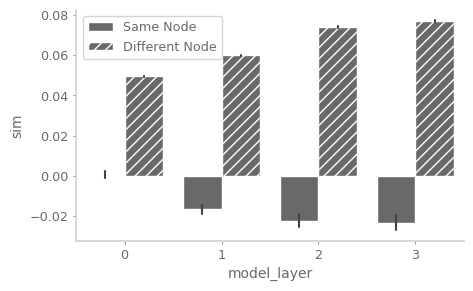

In [25]:
fig, ax = plt.subplots(figsize=(5, 3))
ax = sns.barplot(
    data=pd.concat([
        same_node_df.assign(type='Same Node'),
        diff_node_df.assign(type='Different Node')
    ]),
    x='model_layer', y='sim', hue='type', ax=ax, 
    )

for i, bar in enumerate(ax.patches):
    if bar.get_facecolor() == (0.7642156862745098, 0.5318627450980391, 0.12598039215686285, 1):  # C1 color
        bar.set_hatch('///')
    bar.set_facecolor('dimgray')
plt.legend()
plt.show()

